In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors, topological_category_labels_latex, topological_category_hatches
from src.signal_categories import filetype_category_labels, filetype_category_colors, filetype_category_queries, filetype_category_hatches
from src.signal_categories import del1g_simple_category_labels, del1g_simple_category_colors, del1g_simple_category_queries, del1g_simple_category_hatches
from src.signal_categories import del1g_detailed_category_labels, del1g_detailed_category_colors, del1g_detailed_category_labels_latex, del1g_detailed_category_queries, del1g_detailed_category_hatches

from src.file_locations import intermediate_files_location


# File Loading

In [2]:
#training = "first_combined_training"
#training = "first_wc_training"
#training = "first_lantern_training"

training = "first_mixed_del1g_iso_training"

sig_category_name = "del1g_simple_signal_category"

if sig_category_name == "del1g_simple_signal_category":
    sig_categories = del1g_simple_category_labels
    sig_category_labels_latex = del1g_simple_category_labels
elif sig_category_name == "del1g_detailed_signal_category":
    sig_categories = del1g_detailed_category_labels
    sig_category_labels_latex = del1g_detailed_category_labels_latex
elif sig_category_name == "topological_signal_category":
    sig_categories = topological_category_labels
    sig_category_labels_latex = topological_category_labels_latex
else:
    raise ValueError(f"Invalid sig_category_name: {sig_category_name}")



In [3]:
print("loading all_df.pkl...")
with open(f"{intermediate_files_location}/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/{training}/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

prob_categories = ["prob_" + cat for cat in sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)

num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights         

merged_df = merged_df.query("used_for_testing == True")


loading all_df.pkl...
all_df.shape=(2226353, 242)
loading predictions.pkl...
pred_df.shape=(375264, 22)
merging all_df and predictions.pkl...
weighting up by the fraction of test events: 0.500


In [4]:
print(f"{merged_df.shape=}")
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")
print(f"{presel_merged_df.shape=}")

presel_merged_df


merged_df.shape=(187632, 260)
presel_merged_df.shape=(187632, 260)


,wc_nc_pio_score,wc_single_photon_numu_score,wc_shw_sp_n_20br1_showers,wc_WCPMTInfoTPCClusterID,wc_shw_sp_n_20mev_showers,wc_nc_delta_score,wc_WCPMTInfoClusterLength,wc_WCPMTInfoKSDistance,wc_WCPMTInfoNDF,wc_WCPMTInfoChi2,...,prob_NC1pi0_0p,prob_numuCC1pi0_Np,prob_numuCC1pi0_0p,prob_1pi0_outFV,prob_nueCC_Np,prob_nueCC_0p,prob_multi_pi0,prob_0pi0,prob_other_outFV_dirt,prob_ext
7,-1.320506,-2.101542,0.0,NaN,1.0,-3.831858,NaN,NaN,NaN,NaN,...,0.006109,0.001604,0.000696,0.034453,0.000254,0.000197,0.000290,0.045996,0.112361,0.310072
21,-3.169012,-1.800440,2.0,NaN,2.0,-2.425649,NaN,NaN,NaN,NaN,...,0.002230,0.003393,0.000379,0.002650,0.000151,0.000123,0.000213,0.328072,0.015634,0.052423
60,-2.242356,-3.624760,2.0,NaN,2.0,-7.060031,NaN,NaN,NaN,NaN,...,0.000248,0.023989,0.002379,0.000237,0.000120,0.000080,0.000183,0.901691,0.002164,0.001698
71,-3.127084,-2.554086,1.0,NaN,1.0,-7.687320,NaN,NaN,NaN,NaN,...,0.000783,0.025430,0.002940,0.001229,0.000336,0.000117,0.000307,0.731885,0.001961,0.002983
83,-3.721158,-4.104197,0.0,NaN,1.0,-7.675740,NaN,NaN,NaN,NaN,...,0.000513,0.001059,0.000248,0.001046,0.000054,0.000036,0.000093,0.960735,0.021938,0.003839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226326,0.516163,1.732724,1.0,25.0,1.0,-0.241512,54.332122,0.029771,31.0,103.130792,...,0.000503,0.000335,0.000100,0.000943,0.000042,0.000033,0.000044,0.000760,0.002635,0.003762
2226327,-0.348850,0.985891,1.0,38.0,1.0,3.958367,62.667732,0.075140,31.0,29.134948,...,0.000323,0.000261,0.000097,0.000188,0.000044,0.000034,0.000046,0.000232,0.000180,0.000173
2226343,-1.176651,1.502878,2.0,47.0,2.0,-2.645450,27.363369,0.050947,31.0,7.910047,...,0.002197,0.000285,0.000137,0.003208,0.000071,0.000126,0.000150,0.000800,0.000507,0.000793
2226350,0.831495,0.928880,1.0,39.0,1.0,-3.027475,88.766007,0.049299,31.0,103.542597,...,0.000777,0.000574,0.000230,0.000128,0.001456,0.000142,0.000134,0.000493,0.000686,0.000254


In [5]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()
reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)
presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax

reco_category_queries = []
for i, signal_category in enumerate(sig_categories):
    reco_category_queries.append(f"reco_category_argmax_index == {i}")


# Multi-Class Histograms

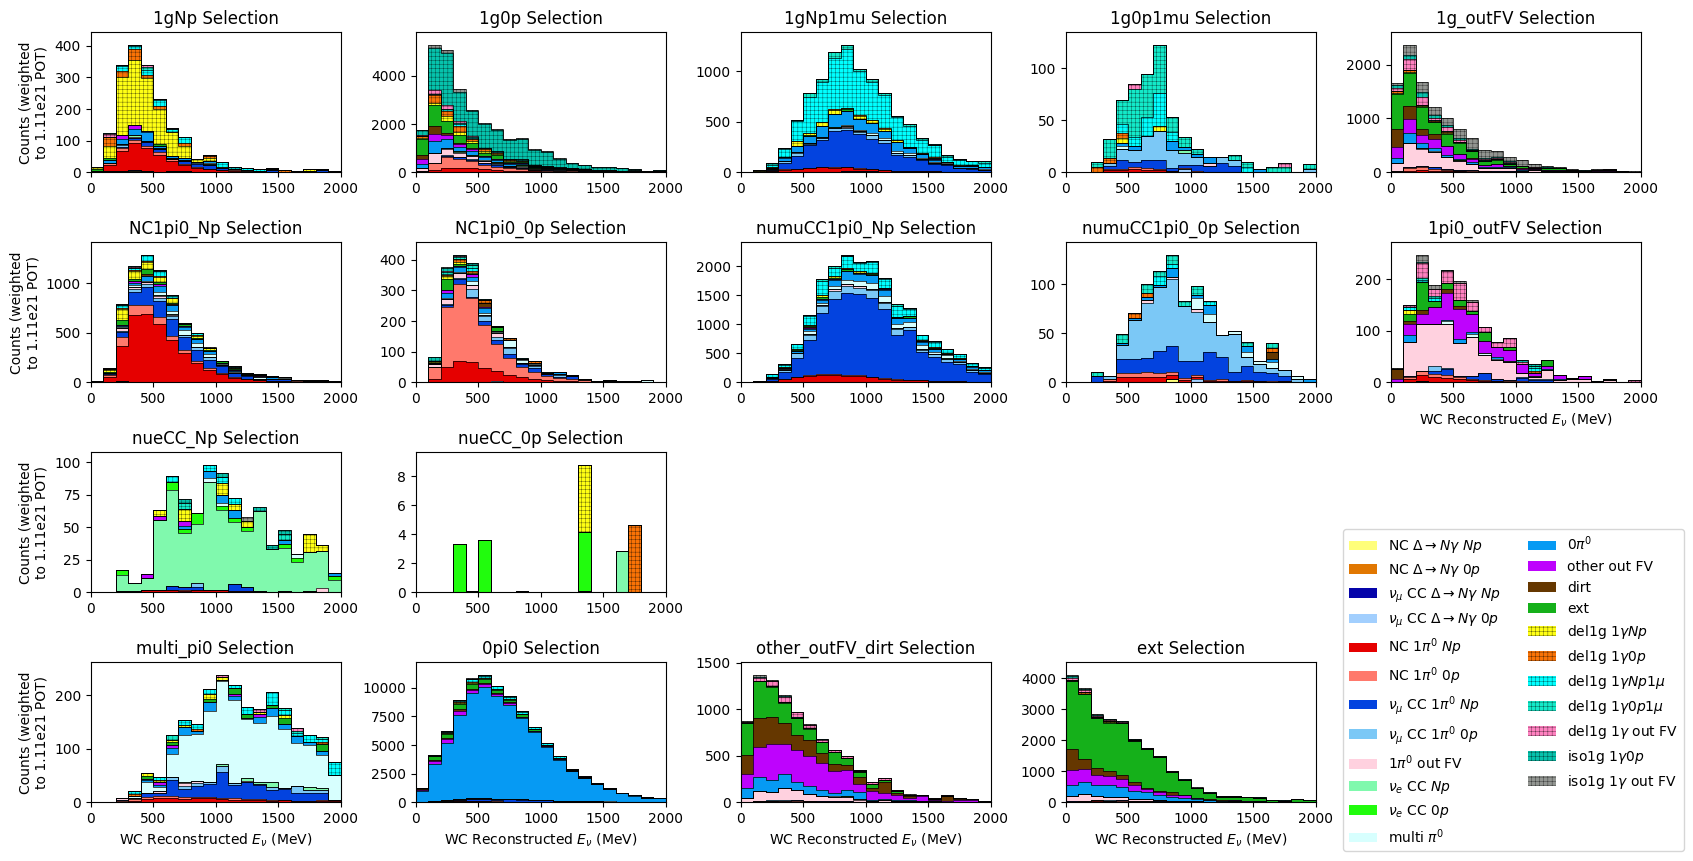

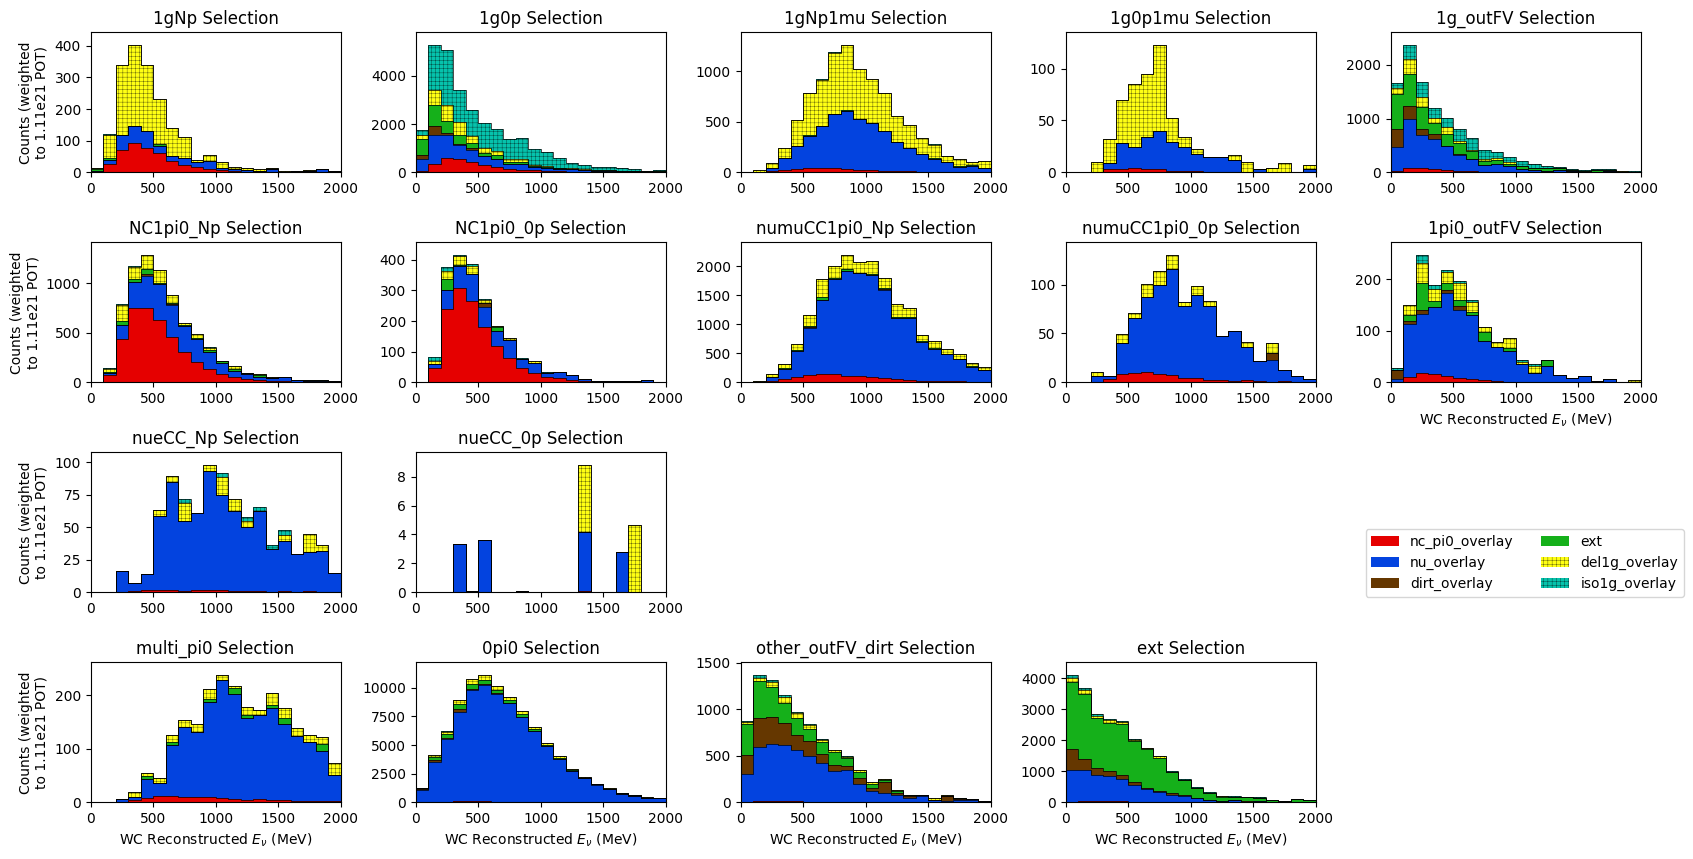

In [6]:
mpl.rcParams['hatch.linewidth'] = 0.2

del1g_norm_factor = 0.5
iso1g_norm_factor = 0.05

for breakdown_type in ["del1g_detailed", "filetype"]: # "topological"
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_labels_latex = topological_category_labels_latex
        breakdown_colors = topological_category_colors
        breakdown_hatches = topological_category_hatches
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_labels_latex = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_hatches = filetype_category_hatches
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype_signal_category == '{label}'")
    elif breakdown_type == "del1g_simple":
        breakdown_labels = del1g_simple_category_labels
        breakdown_labels_latex = del1g_simple_category_labels
        breakdown_colors = del1g_simple_category_colors
        breakdown_hatches = del1g_simple_category_hatches
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"del1g_simple_signal_category == '{label}'")
    elif breakdown_type == "del1g_detailed":
        breakdown_labels = del1g_detailed_category_labels
        breakdown_labels_latex = del1g_detailed_category_labels_latex
        breakdown_colors = del1g_detailed_category_colors
        breakdown_hatches = del1g_detailed_category_hatches
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"del1g_detailed_signal_category == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")

    fig, axs = plt.subplots(4, 5, figsize=(20, 10))
    axs = axs.flatten()

    bins = np.linspace(0, 2000, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    for i in range(len(sig_categories)):

        signal_category = sig_categories[i]
        signal_category_latex = sig_category_labels_latex[i]

        sel_df = presel_merged_df.query(reco_category_queries[i])

        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], weights=curr_df["wc_net_weight"], bins=bins)[0])

        axnum = i
        if i >= 12: # background categories, start new row
            axnum = i + 3

        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                breakdown_count = breakdown_count * iso1g_norm_factor
            elif "del1g" in breakdown_label:
                breakdown_count = breakdown_count * del1g_norm_factor

            n, _, _ = axs[axnum].hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
            axs[axnum].hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n
        axs[axnum].set_ylim(0, np.max(bottom) * 1.1)

        if axnum in [15, 16, 17, 18, 9]:
            axs[axnum].set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
        if axnum % 5 == 0: # Only show y-label for leftmost column
            axs[axnum].set_ylabel("Counts (weighted\nto 1.11e21 POT)")
        axs[axnum].set_title(f"{signal_category_latex} Selection")
        axs[axnum].set_xlim(0, 2000)

        if axnum == 18:
            axs[axnum].legend(ncol=2, loc='upper right', bbox_to_anchor=(2.5, 2))
    
    for axnum in range(20):
        if axnum in [12, 13, 14, 19]:
            axs[axnum].remove()

    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    plt.savefig(f"../plots/multiclass_histograms_{training}_{breakdown_type}.pdf")
    plt.savefig(f"../plots/multiclass_histograms_{training}_{breakdown_type}.png")
    plt.show()


# Checking Event Weights

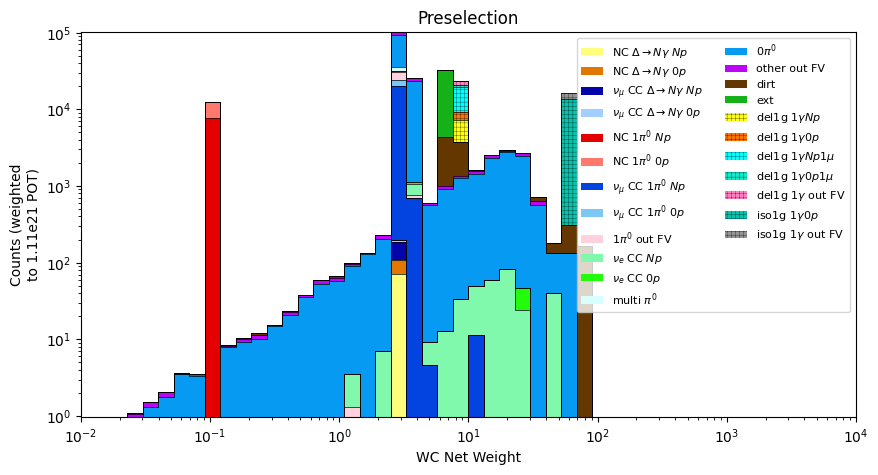

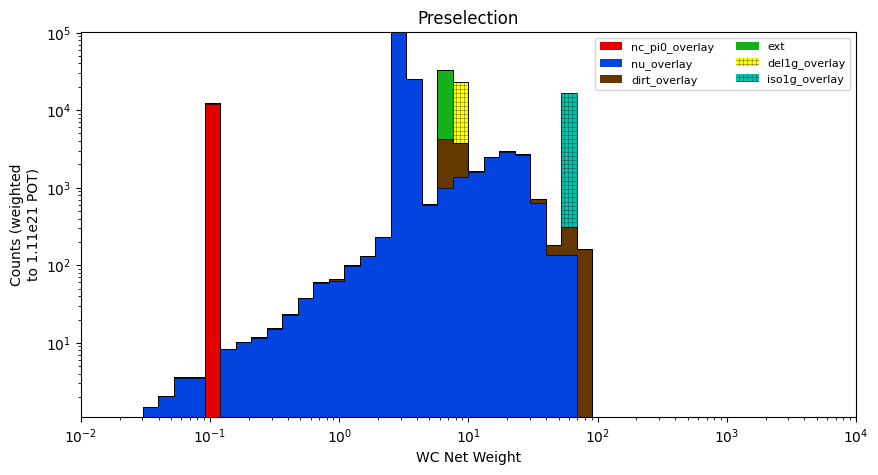

In [7]:
del1g_norm_factor = 0.5
iso1g_norm_factor = 0.05

for breakdown_type in ["del1g_detailed", "filetype"]:
    if breakdown_type == "del1g_detailed":
        breakdown_labels = del1g_detailed_category_labels
        breakdown_colors = del1g_detailed_category_colors
        breakdown_hatches = del1g_detailed_category_hatches
        breakdown_labels_latex = del1g_detailed_category_labels_latex
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"del1g_detailed_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_labels_latex = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_hatches = filetype_category_hatches
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype_signal_category == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")

    plt.figure(figsize=(10, 5))
    ax = plt.gca()

    bins = np.logspace(-2, 4, 51)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    multi_bin_centers = [bin_centers] * len(breakdown_labels)
    outline_colors = ["k"] * len(breakdown_labels)

    sel_df = presel_merged_df
    counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = sel_df.query(breakdown_queries[breakdown_i])
        counts.append(np.histogram(curr_df["wc_net_weight"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

    bottom = np.zeros(len(bins)-1)
    for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
        if "iso1g" in breakdown_label:
            breakdown_count = breakdown_count * iso1g_norm_factor
        elif "del1g" in breakdown_label:
            breakdown_count = breakdown_count * del1g_norm_factor
        n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
        ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
        if breakdown_i == 0:
            bottom = n
        else:
            bottom += n

    plt.xlabel(r"WC Net Weight")
    plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
    plt.xlim(bins[0], bins[-1])
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(loc="upper right", ncol=2, fontsize=8)
    plt.title("Preselection")
    plt.show()



# Post-Selection Studies

In [8]:
one_g_reco_category_argmax_indices = []
for i, signal_category in enumerate(sig_categories):
    if "1g" in signal_category:
        one_g_reco_category_argmax_indices.append(i)

combined_1g_query = ""
for i in one_g_reco_category_argmax_indices:
    combined_1g_query += f"reco_category_argmax_index == {i} or "
combined_1g_query = combined_1g_query[:-4]

all_1g_sel_df = presel_merged_df.query(combined_1g_query)

print(f"{presel_merged_df.shape=}")
print(f"{all_1g_sel_df.shape=}")

presel_merged_df.shape=(187632, 261)
all_1g_sel_df.shape=(58012, 261)


## Blip Veto

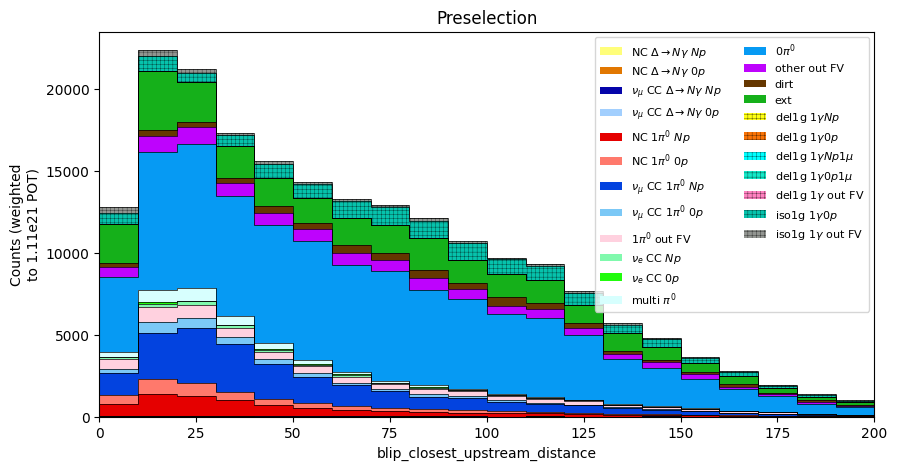

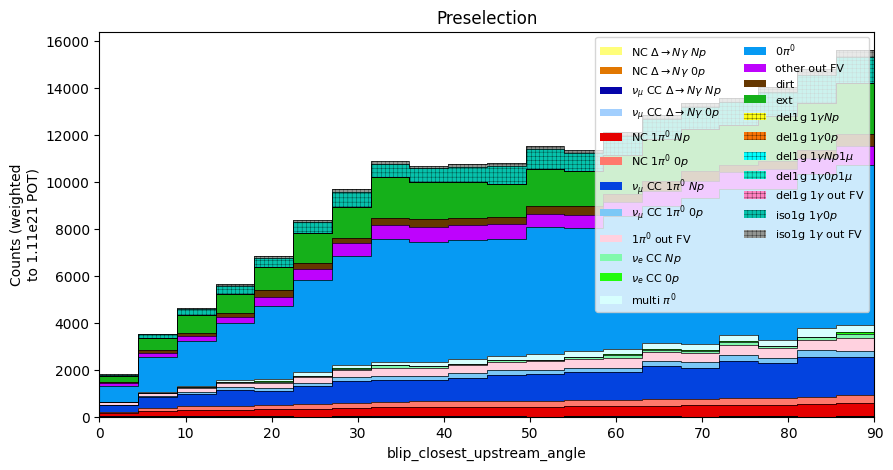

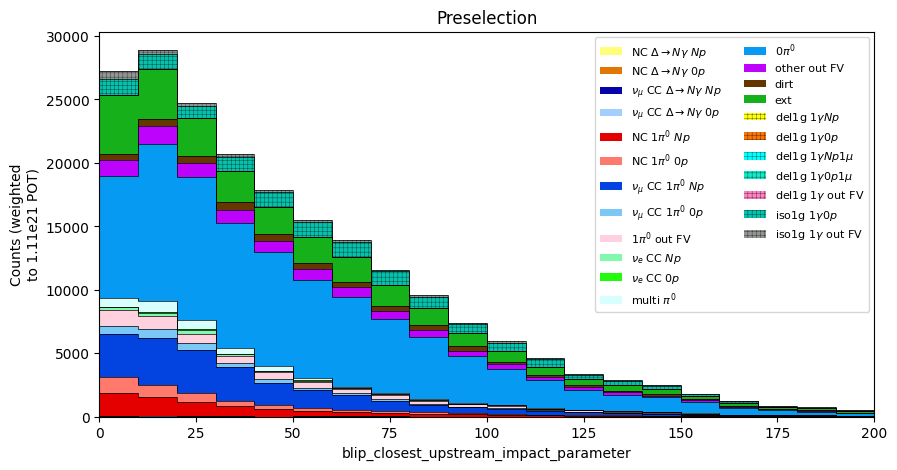

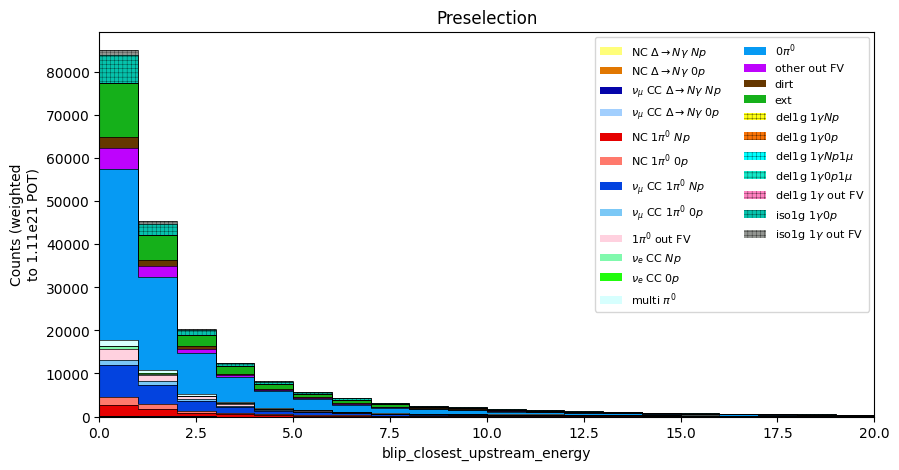

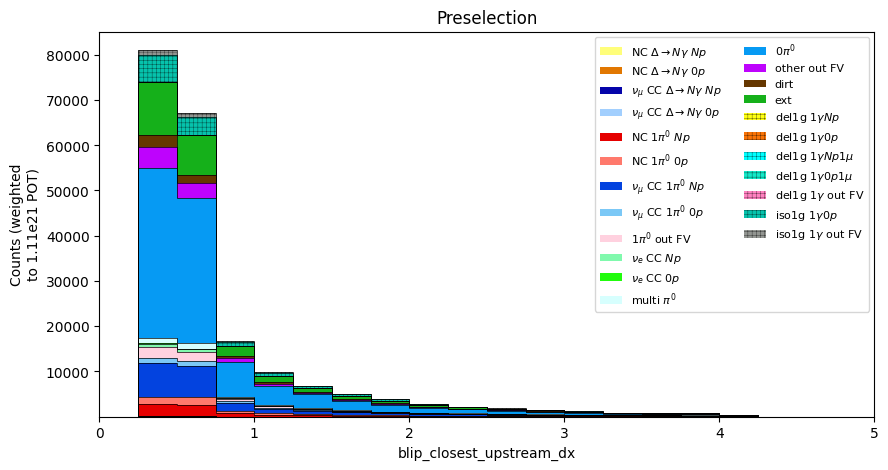

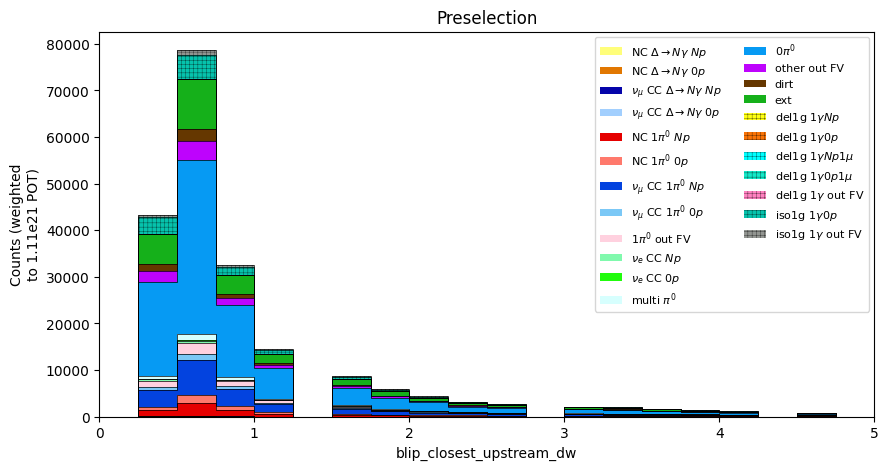

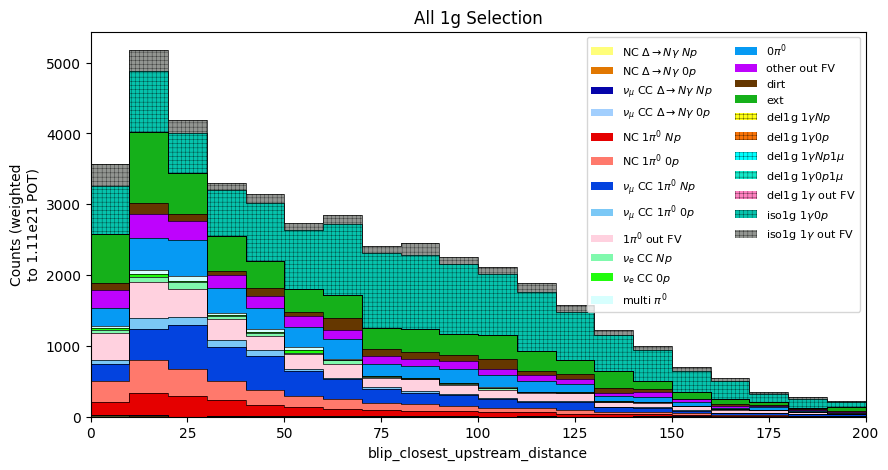

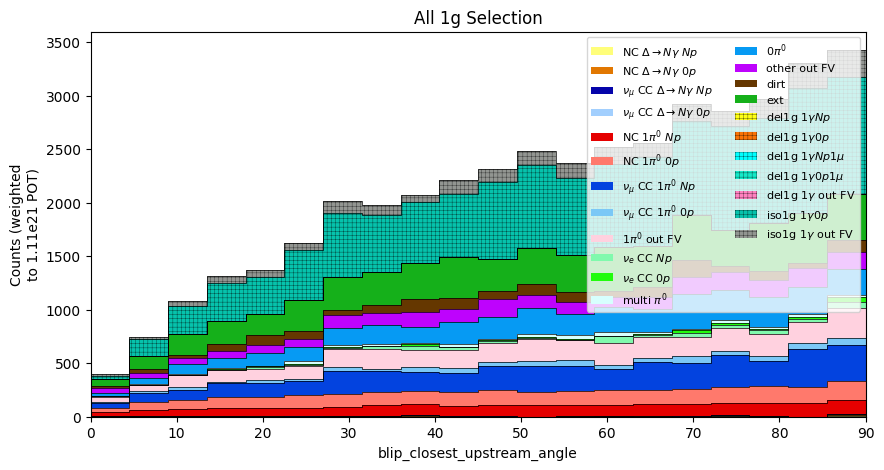

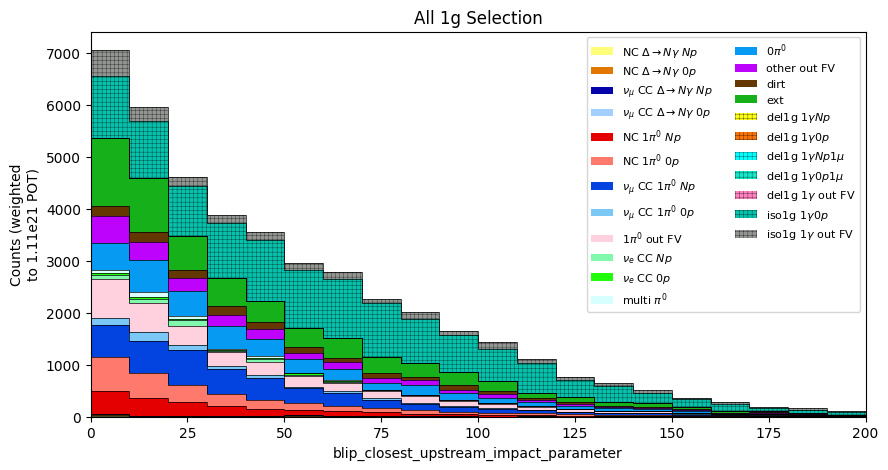

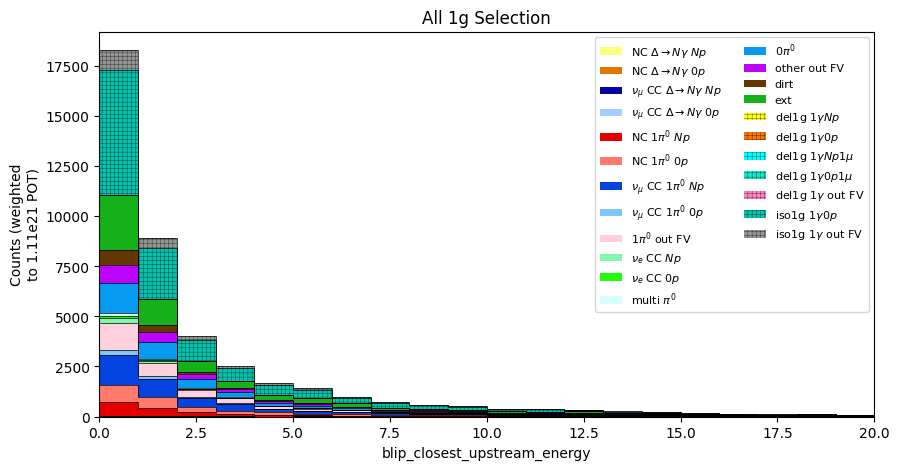

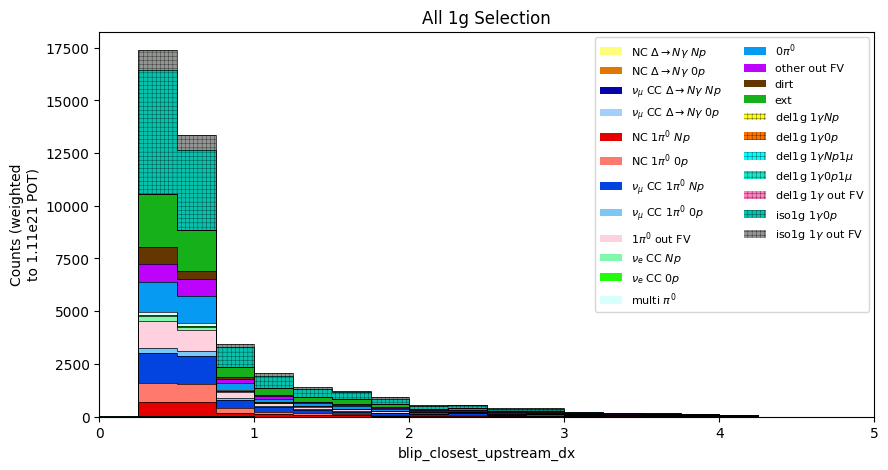

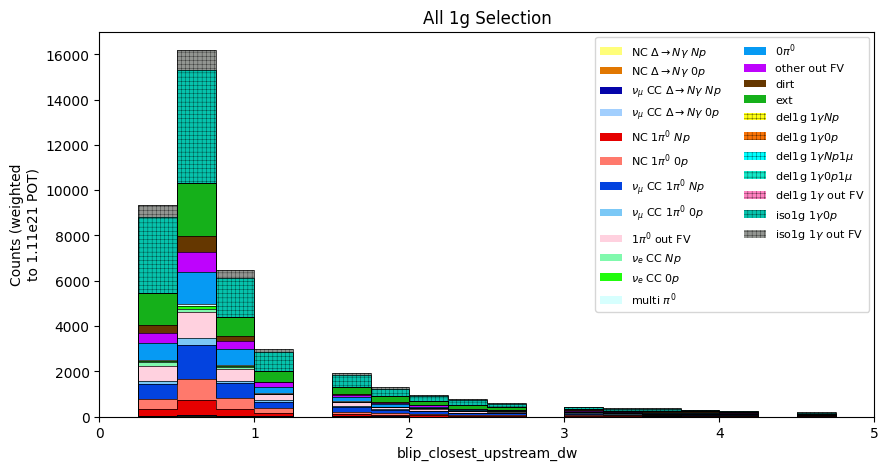

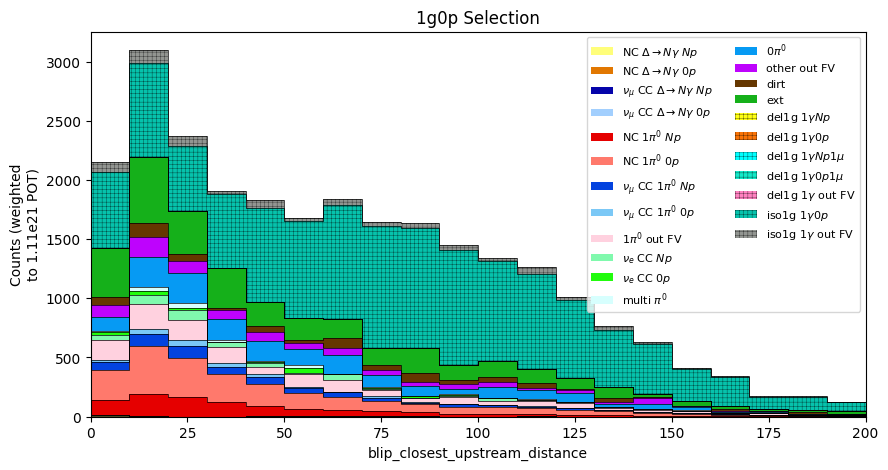

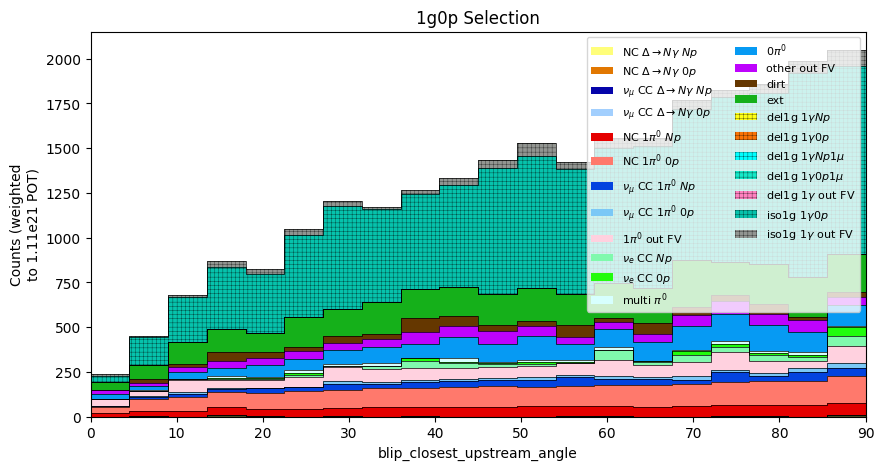

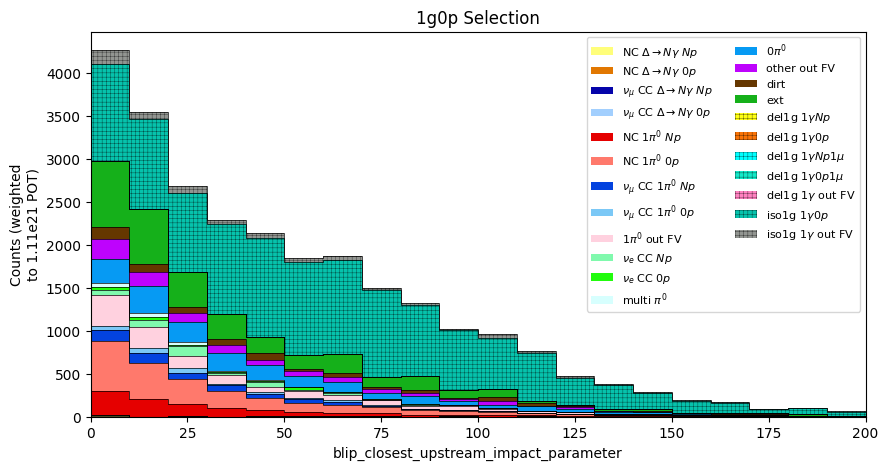

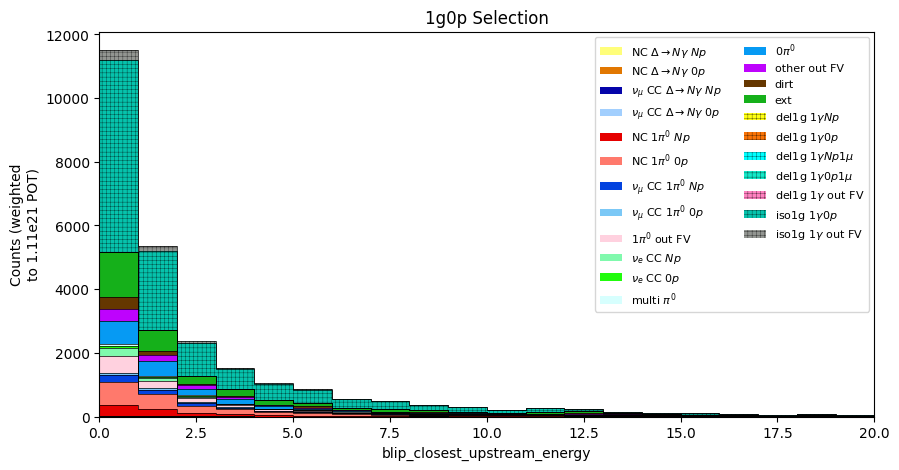

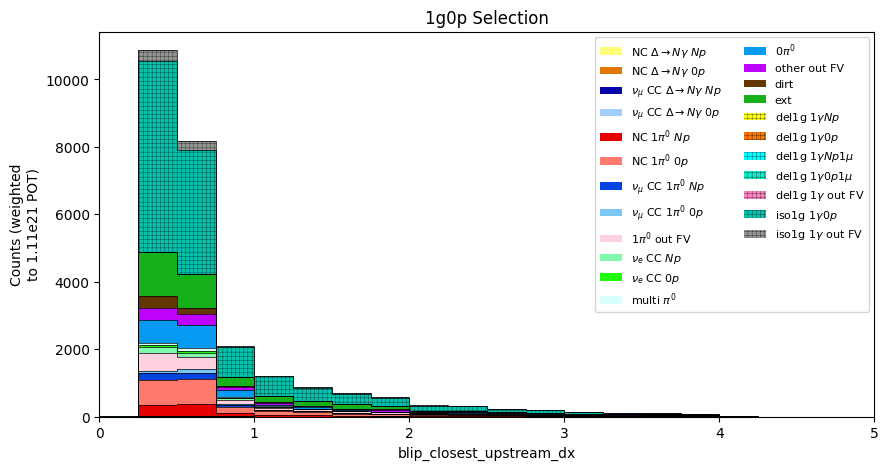

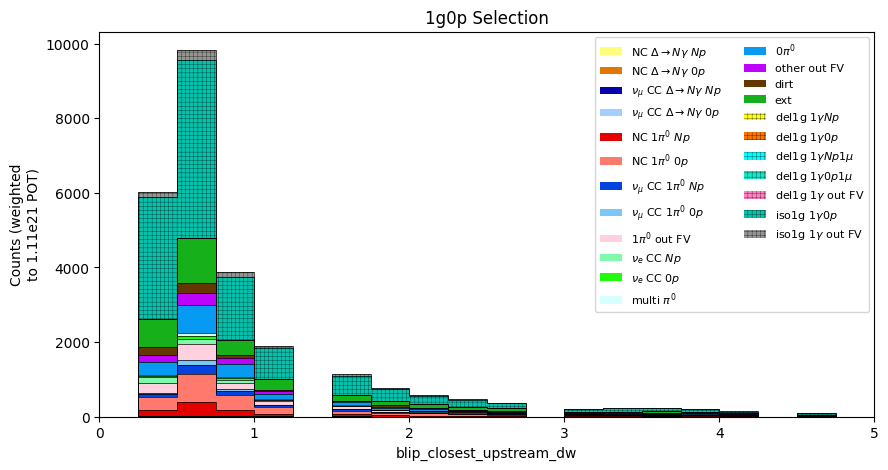

In [9]:
del1g_norm_factor = 0
iso1g_norm_factor = 0.05

for breakdown_type in ["del1g_detailed"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype_signal_category == '{label}'")
    elif breakdown_type == "del1g_detailed":
        breakdown_labels = del1g_detailed_category_labels
        breakdown_colors = del1g_detailed_category_colors
        breakdown_hatches = del1g_detailed_category_hatches
        breakdown_labels_latex = del1g_detailed_category_labels_latex
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"del1g_detailed_signal_category == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")
    for sel_type in ["presel", "all_1g", "1g0p"]:
        if sel_type == "presel":
            sel_df = presel_merged_df
        elif sel_type == "all_1g":
            sel_df = all_1g_sel_df
        elif sel_type == "1g0p":
            sel_df = presel_merged_df.query("reco_category_argmax_index == 1")
                
        blip_postprocessing_vars_bin_ranges = [
            ("blip_closest_upstream_distance", 0, 200),
            ("blip_closest_upstream_angle", 0, 90),
            ("blip_closest_upstream_impact_parameter", 0, 200),
            ("blip_closest_upstream_energy", 0, 20),
            ("blip_closest_upstream_dx", 0, 5),
            ("blip_closest_upstream_dw", 0, 5),
        ]

        for var, min_val, max_val in blip_postprocessing_vars_bin_ranges:

            plt.figure(figsize=(10, 5))
            ax = plt.gca()
            bins = np.linspace(min_val, max_val, 21)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            multi_bin_centers = [bin_centers] * len(breakdown_labels)
            outline_colors = ["k"] * len(breakdown_labels)
            counts = []
            for breakdown_i, breakdown_label in enumerate(breakdown_labels):
                curr_df = sel_df.query(breakdown_queries[breakdown_i])
                counts.append(np.histogram(curr_df[var].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
            
            bottom = np.zeros(len(bins)-1)
            for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
                if "iso1g" in breakdown_label:
                    breakdown_count = breakdown_count * iso1g_norm_factor
                elif "del1g" in breakdown_label:
                    breakdown_count = breakdown_count * del1g_norm_factor
                n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
                ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
                if breakdown_i == 0:
                    bottom = n
                else:
                    bottom += n

            plt.xlabel(var)
            plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
            plt.xlim(bins[0], bins[-1])
            plt.legend(loc="upper right", ncol=2, fontsize=8)
            if sel_type == "presel":
                plt.title(f"Preselection")
            elif sel_type == "1g0p":
                plt.title(f"1g0p Selection")
            elif sel_type == "all_1g":
                plt.title(f"All 1g Selection")

            plt.show()


## Nanosecond Timing

In [10]:
del1g_norm_factor = 0.5
iso1g_norm_factor = 0.05

# related to https://github.com/brb-rightback/ns_demo_MCC9.10/blob/main/ns_demo_MCC9.10.ipynb
# TODO: Validate this with data and showers, see https://microboone-docdb.fnal.gov/cgi-bin/sso/ShowDocument?docid=44781
# Also check the manually applied shifts for all the different time periods

data_presel_merged_df = presel_merged_df.query("filetype == 'data' or filetype == 'ext'")
mc_presel_merged_df = presel_merged_df.query("not (filetype == 'data' or filetype == 'ext')")

data_presel_merged_df["non_merge_time"] = data_presel_merged_df["wc_evtTimeNS"]
mc_presel_merged_df["non_merge_time"] = mc_presel_merged_df["wc_evtTimeNS_cor"] + 1500 # manually shifting MC to approximately match data

run = data_presel_merged_df["run"].to_numpy()
evtTimeNS = data_presel_merged_df["wc_evtTimeNS"].to_numpy()
new_times = []
for i in range(len(evtTimeNS)):
    gap=18.936
    Shift=0
    TThelp=0
    if (run[i] >= 19500): Shift=2920.5 
    elif (run[i] >= 17380): Shift=2916.0 
    elif (run[i] >= 13697): Shift = 3147.3
    elif (run[i] >= 10812): Shift = 3568.5 
    elif (run[i] >= 8321): Shift = 3610.7
    elif (run[i] >= 5800): Shift = 3164.4
    elif (run[i] > 0 ): Shift = 3168.9
    TThelp = evtTimeNS[i]-Shift+gap*0.5
    if np.isinf(TThelp):
        TThelp = np.nan
    TT_merged = -9999.
    if(TThelp>=0): 
        TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
    new_times.append(TT_merged)
data_presel_merged_df["merge_time"] = new_times

evtTimeNS = mc_presel_merged_df["wc_evtTimeNS_cor"].to_numpy()
new_times = []
for i in range(len(evtTimeNS)):
    gap=18.936
    Shift=5.8-0.3
    TThelp=0
    TThelp = np.nan_to_num(evtTimeNS[i]-Shift+gap*0.5,nan=-9999)
    TT_merged = -9999.
    if(TThelp>=0):
        TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
    new_times.append(TT_merged)
mc_presel_merged_df["merge_time"] = new_times

presel_merged_df = pd.concat([data_presel_merged_df, mc_presel_merged_df])
all_1g_sel_df = presel_merged_df.query(combined_1g_query)


/tmp/ipykernel_3338050/1561817919.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_presel_merged_df["non_merge_time"] = data_presel_merged_df["wc_evtTimeNS"]
/tmp/ipykernel_3338050/1561817919.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_presel_merged_df["non_merge_time"] = mc_presel_merged_df["wc_evtTimeNS_cor"] + 1500 # manually shifting MC to approximately match data
/tmp/ipykernel_3338050/1561817919.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

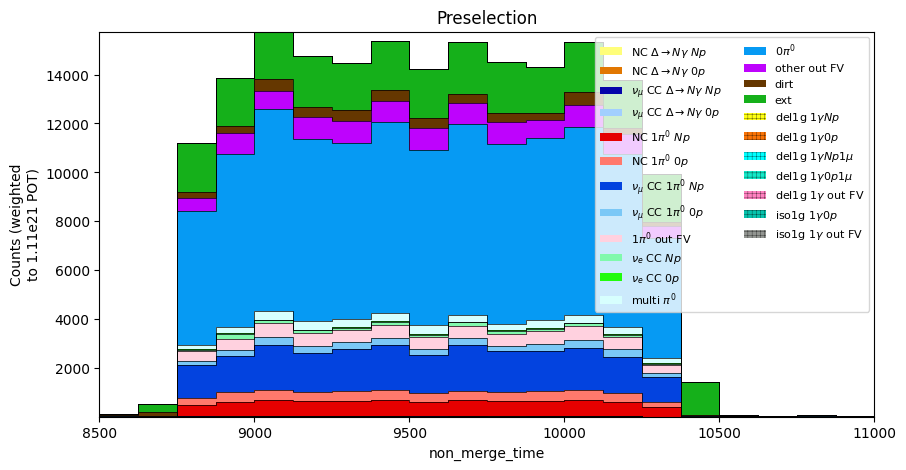

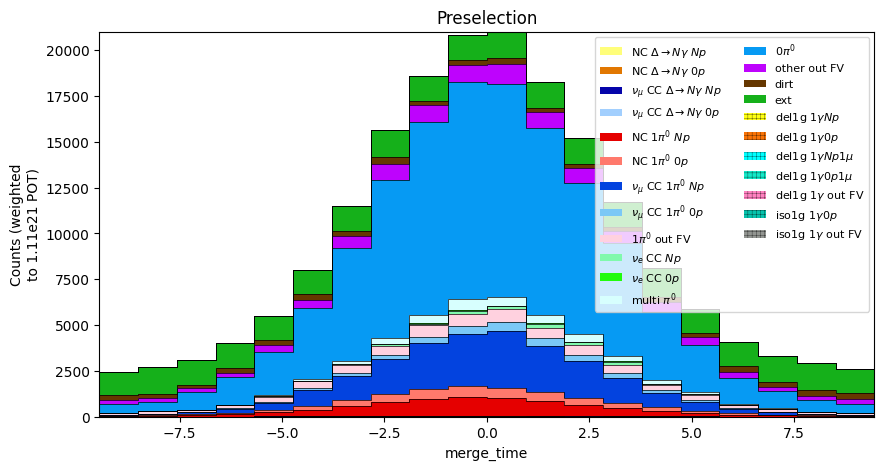

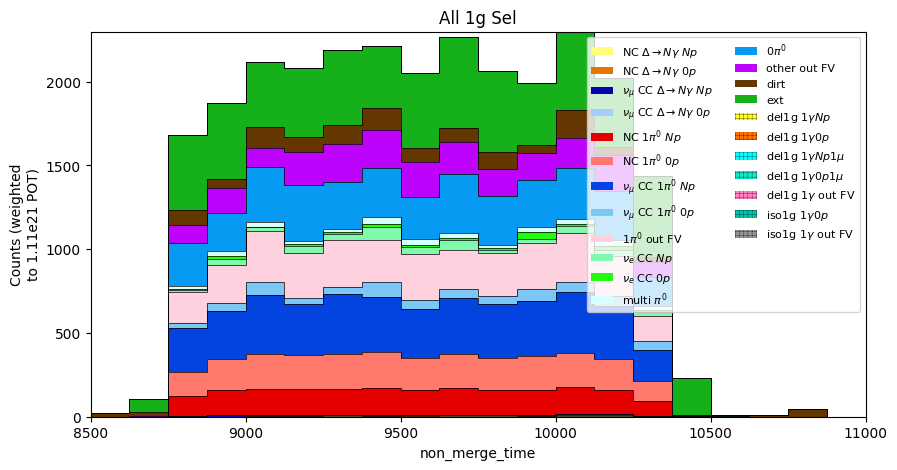

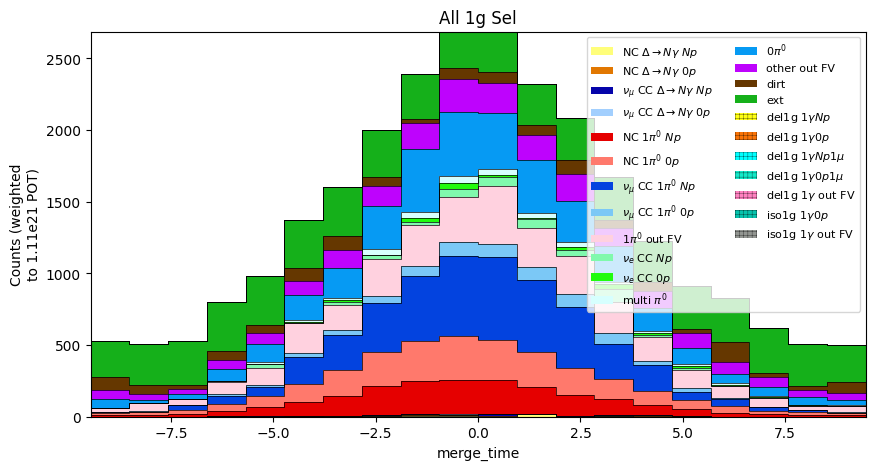

In [11]:
for breakdown_type in ["del1g_detailed"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype_signal_category == '{label}'")
    elif breakdown_type == "del1g_detailed":
        breakdown_labels = del1g_detailed_category_labels
        breakdown_colors = del1g_detailed_category_colors
        breakdown_hatches = del1g_detailed_category_hatches
        breakdown_labels_latex = del1g_detailed_category_labels_latex
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"del1g_detailed_signal_category == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")
    
    for sel_type in ["presel", "all_1g"]:
        if sel_type == "presel":
            sel_df = presel_merged_df
        elif sel_type == "all_1g":
            sel_df = all_1g_sel_df


        plt.figure(figsize=(10, 5))
        ax = plt.gca()
        bins = np.linspace(8500, 11000, 21)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["non_merge_time"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                breakdown_count = breakdown_count * iso1g_norm_factor
            elif "del1g" in breakdown_label:
                breakdown_count = breakdown_count * del1g_norm_factor
            n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
            ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n

        plt.xlabel("non_merge_time")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right", ncol=2, fontsize=8)
        if sel_type == "presel":
            plt.title(f"Preselection")
        else:
            plt.title(f"All 1g Sel")
        plt.show()


        plt.figure(figsize=(10, 5))
        ax = plt.gca()
        bins = np.linspace(-9.462531250000058, 9.462531250000058, 21)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["merge_time"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                breakdown_count = breakdown_count * iso1g_norm_factor
            elif "del1g" in breakdown_label:
                breakdown_count = breakdown_count * del1g_norm_factor
            n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
            ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n

        plt.xlabel("merge_time")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right", ncol=2, fontsize=8)
        if sel_type == "presel":
            plt.title(f"Preselection")
        else:
            plt.title(f"All 1g Sel")
        plt.show()


## Out-TPC PMT Veto

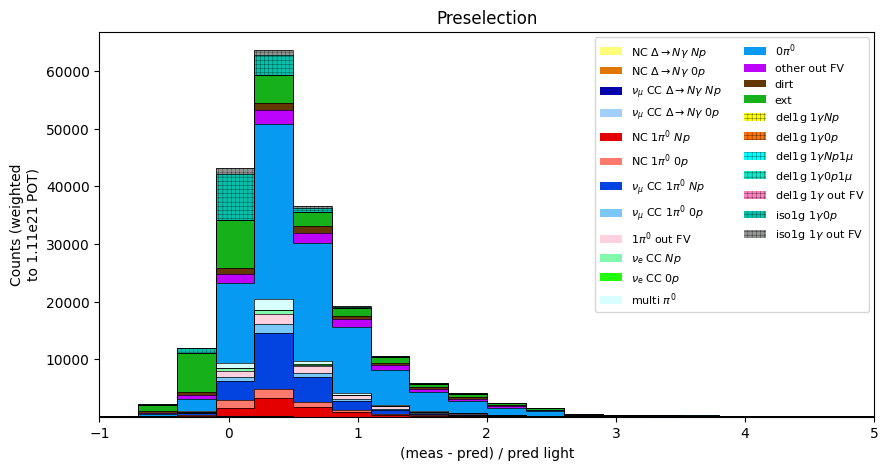

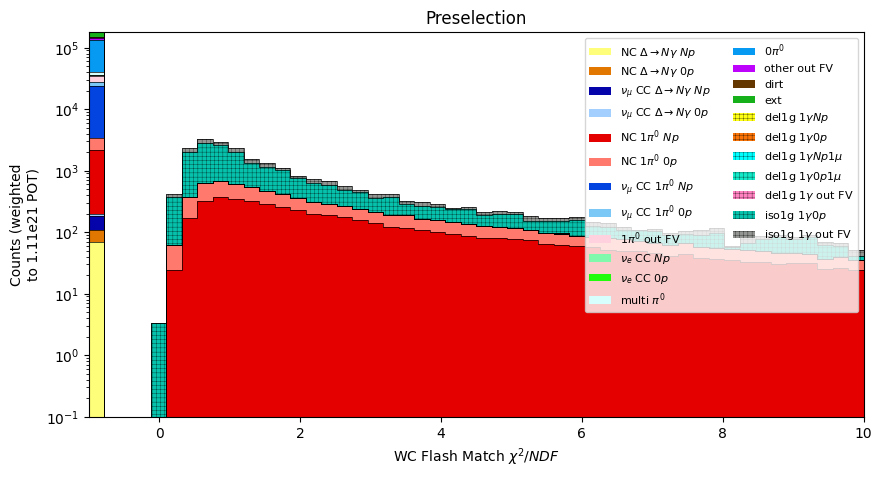

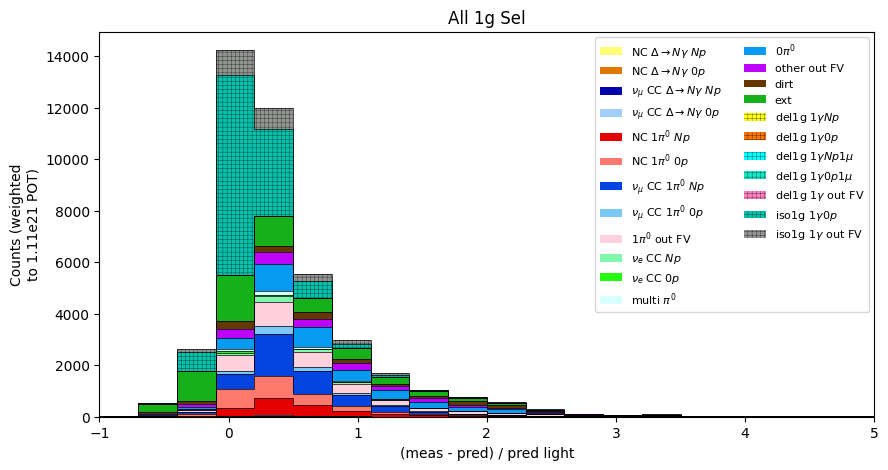

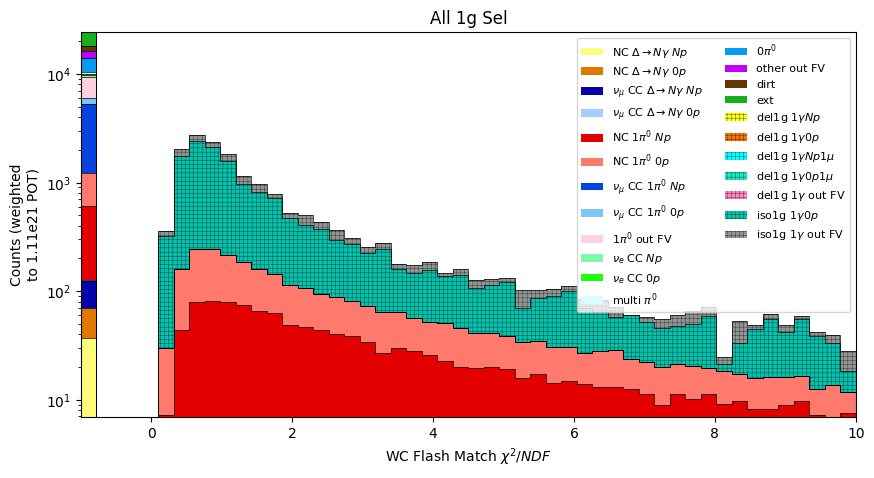

In [24]:
# TODO: Add more detailed PMT-by-PMT information, see https://github.com/kpulido444/REU_uboone_photon_rejection
# Could require SUPRPRISE files with newer WC PMT info

del1g_norm_factor = 0
iso1g_norm_factor = 0.05

print("WARNING: Missing detailed PMT Information for run 4b v10_04_07_09 files, for these missing file information we set chi2/ndf to -1!")

for breakdown_type in ["del1g_detailed"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype_signal_category == '{label}'")
    elif breakdown_type == "del1g_detailed":
        breakdown_labels = del1g_detailed_category_labels
        breakdown_colors = del1g_detailed_category_colors
        breakdown_hatches = del1g_detailed_category_hatches
        breakdown_labels_latex = del1g_detailed_category_labels_latex
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"del1g_detailed_signal_category == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")
    
    for sel_type in ["presel", "all_1g"]:
        if sel_type == "presel":
            sel_df = presel_merged_df
        elif sel_type == "all_1g":
            sel_df = all_1g_sel_df

        plt.figure(figsize=(10, 5))
        ax = plt.gca()
        bins = np.linspace(-1, 5, 21)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            ratio = (curr_df["wc_flash_measPe"].to_numpy() - curr_df["wc_flash_predPe"].to_numpy()) / curr_df["wc_flash_predPe"].to_numpy()
            counts.append(np.histogram(ratio, weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                breakdown_count = breakdown_count * iso1g_norm_factor
            elif "del1g" in breakdown_label:
                breakdown_count = breakdown_count * del1g_norm_factor
            n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
            ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n
        plt.xlabel("(meas - pred) / pred light")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right", ncol=2, fontsize=8)
        if sel_type == "presel":
            plt.title(f"Preselection")
        else:
            plt.title(f"All 1g Sel")
        plt.show()

        plt.figure(figsize=(10, 5))
        ax = plt.gca()
        bins = np.linspace(-1, 10, 51)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            ratio = curr_df["wc_WCPMTInfoChi2"].to_numpy() / curr_df["wc_WCPMTInfoNDF"].to_numpy()
            ratio = np.nan_to_num(ratio, nan=-1, posinf=-1, neginf=-1)
            counts.append(np.histogram(ratio, weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                breakdown_count = breakdown_count * iso1g_norm_factor
            elif "del1g" in breakdown_label:
                breakdown_count = breakdown_count * del1g_norm_factor
            n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
            ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n
        plt.xlabel(r"WC Flash Match $\chi^2 / NDF$")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right", ncol=2, fontsize=8)
        if sel_type == "presel":
            plt.title(f"Preselection")
        else:
            plt.title(f"All 1g Sel")
        plt.yscale("log")
        plt.show()


## Out-TPC CRT Veto

In [13]:
# TODO: Look at CRT information, and if we can identify in-time out-TPC activity associated with an event
# (even if there's no clean CRT track indicating a through-going cosmic muon)


# Out-TPC Geometric BDT

In [14]:
# TODO: Look at just shower position and direction, use that to separate in-FV vs out-FV reco-1g events


## Spacepoint SSV

In [15]:
# TODO: https://github.com/leehagaman/spacepoint_ssv
# Will require processing ntuples with all cosmic spacepoints turned on
